# Inicialização

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter6()
# Isto é necessário para apresentar os gráficos deste notebook
from plots.chapter6 import *

Finished!


In [ ]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms.v2 import Compose, ToImage, Normalize, \
ToPILImage, Resize, ToDtype
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, \
MultiStepLR, CyclicLR, LambdaLR, ExponentialLR, CosineAnnealingLR

from stepbystep.v2 import StepByStep
from data_generation.rps import download_rps

# Preparação e Geração dos dados

In [ ]:
%run -i data_generation/simple_linear_regression.py
%run -i data_preparation/v2.py

<Figure size 640x480 with 0 Axes>

# Aplicando um Scheduler genérico



In [ ]:
#Criando um otimizador qualquer
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
#Criando um Scheduler StepLR
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)
#Os argumentos do scheduler são: o otimizador utilizado;
#o tamanho do passo, ou seja, qual o intervalo de épocas que iremos alterar a taxa de aprendizado;
#e o fator gamma, que é multiplicado pela taxa de aprendizado.


for epoch in range(4):
    # Loop de treinamento aqui

    print(dummy_scheduler.get_last_lr())
    # Primeiro chamamos a etapa do Otimizador
    dummy_optimizer.step()
    # Então chamamos a etapa do Scheduler
    dummy_scheduler.step()

    dummy_optimizer.zero_grad()

[0.01]
[0.01]
[0.001]
[0.001]


# Epoch Schedulers

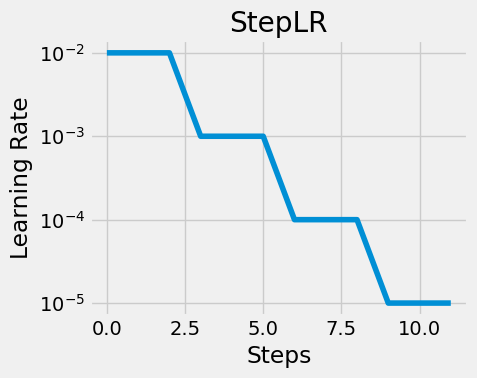

In [ ]:
#Aplicando o StepLR com fator de multiplicação gamma igual a 0.1 e atualização a cada 3 épocas

dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = StepLR(dummy_optimizer, step_size=3, gamma=0.1)


fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

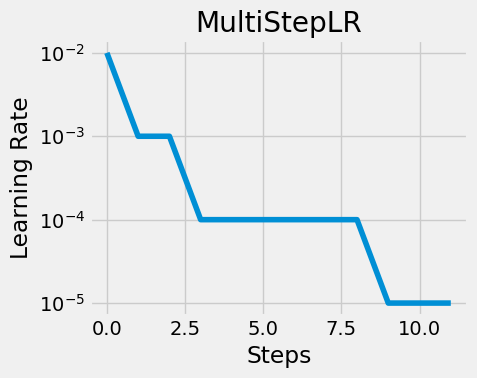

In [ ]:
#Aplicando o MultiStepLR com fator de multiplicação gamma igual a 0.1 e atualização a cada época 1, 3 e 9

dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = MultiStepLR(dummy_optimizer,milestones=[1,3,9],gamma=0.1)

fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

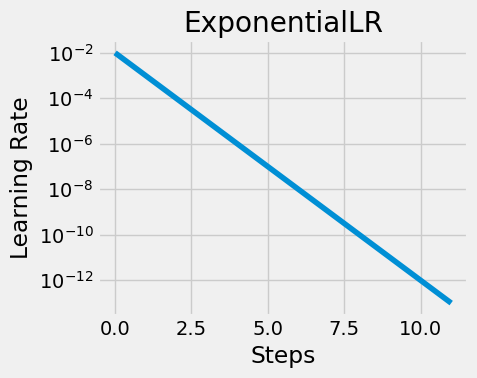

In [ ]:
#Aplicando o ExponentialLR com faor de multiplicação gamma igual a 0.1

dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = ExponentialLR(dummy_optimizer,gamma=0.1)

fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

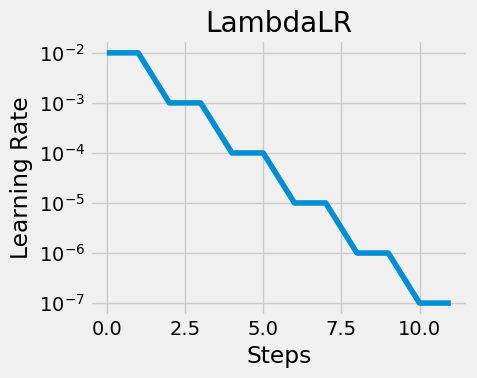

In [ ]:
#Aplicando o LambdaLR com um função que replica o StepLR utilizado no exemplo genérico

dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch//2))

fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

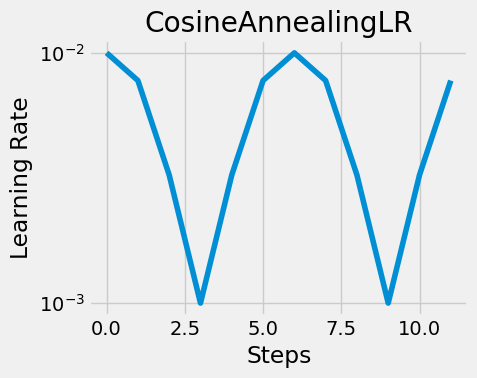

In [ ]:
#Aplicando o CosineAnnealingLR com número de iterações máximas igual a 3 e LR mínimo igual a 0.001

dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = CosineAnnealingLR(dummy_optimizer, 3, 0.001)

fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

# Validation Loss Schedulers


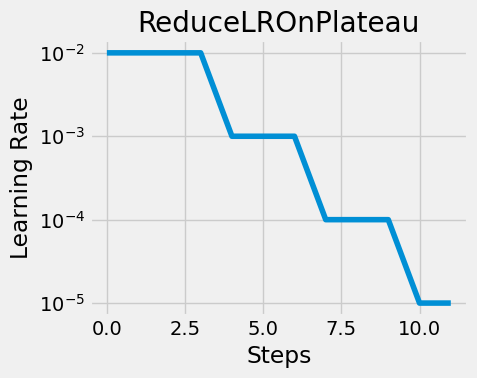

In [ ]:
#Aplicando o ReduceLRonPlateau com grau de paciência 2 e fator de multiplicação 0.1

dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = ReduceLROnPlateau(dummy_optimizer, patience=2, factor=0.1)

fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

# Mini-Batch Schedulers

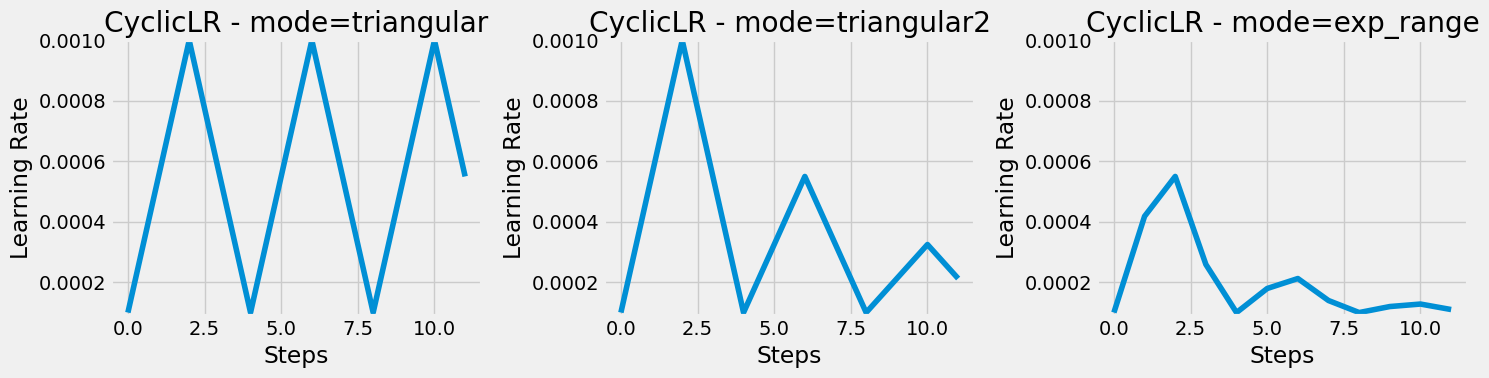

In [ ]:
#Comparação do CyclicLR com diferentes modos

dummy_parm = [nn.Parameter(torch.randn(1))]
dummy_optimizer = optim.SGD(dummy_parm, lr=0.01)

dummy_scheduler1 = CyclicLR(dummy_optimizer, base_lr=1e-4,
max_lr=1e-3, step_size_up=2, mode='triangular')

dummy_scheduler2 = CyclicLR(dummy_optimizer, base_lr=1e-4,
max_lr=1e-3, step_size_up=2, mode='triangular2')

dummy_scheduler3 = CyclicLR(dummy_optimizer, base_lr=1e-4,
max_lr=1e-3, step_size_up=2, mode='exp_range', gamma=np.sqrt(.5))

fig = figure26(dummy_optimizer, (dummy_scheduler1, dummy_scheduler2, dummy_scheduler3))

# Utilizando Schedulers

In [ ]:
setattr(StepByStep, 'scheduler', None)
setattr(StepByStep, 'is_batch_lr_scheduler', False)

def set_lr_scheduler(self, scheduler):
    # Makes sure the scheduler in the argument is assigned to the
    # optimizer we're using in this class
    if scheduler.optimizer == self.optimizer:
        self.scheduler = scheduler
        if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or
            isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or
            isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)):
            self.is_batch_lr_scheduler = True
        else:
            self.is_batch_lr_scheduler = False

setattr(StepByStep, 'set_lr_scheduler', set_lr_scheduler)

In [ ]:
setattr(StepByStep, 'learning_rates', [])

def _epoch_schedulers(self, val_loss):
    if self.scheduler:
        if not self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(StepByStep, '_epoch_schedulers', _epoch_schedulers)

In [ ]:
def train(self, n_epochs, seed=42):
    # To ensure reproducibility of the training process
    self.set_seed(seed)

    for epoch in range(n_epochs):
        # Keeps track of the numbers of epochs
        # by updating the corresponding attribute
        self.total_epochs += 1

        # inner loop
        # Performs training using mini-batches
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # VALIDATION
        # no gradients in validation!
        with torch.no_grad():
            # Performs evaluation using mini-batches
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        self._epoch_schedulers(val_loss)

        # If a SummaryWriter has been set...
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            # Records both losses for each epoch under the main tag "loss"
            self.writer.add_scalars(main_tag='loss',
                                    tag_scalar_dict=scalars,
                                    global_step=epoch)

    if self.writer:
        # Closes the writer
        self.writer.close()

setattr(StepByStep, 'train', train)

In [ ]:
def _mini_batch_schedulers(self, frac_epoch):
    if self.scheduler:
        if self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                self.scheduler.step(self.total_epochs + frac_epoch)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(StepByStep, '_mini_batch_schedulers', _mini_batch_schedulers)


In [ ]:
def _mini_batch(self, validation=False):
    # The mini-batch can be used with both loaders
    # The argument `validation`defines which loader and
    # corresponding step function is going to be used
    if validation:
        data_loader = self.val_loader
        step_fn = self.val_step_fn
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    if data_loader is None:
        return None

    n_batches = len(data_loader)
    # Once the data loader and step function, this is the same
    # mini-batch loop we had before
    mini_batch_losses = []
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

        if not validation:
            self._mini_batch_schedulers(i / n_batches)

    loss = np.mean(mini_batch_losses)
    return loss

setattr(StepByStep, '_mini_batch', _mini_batch)

# Testando caminhos dos Schedulers

In [ ]:
# Generating data for the plots
torch.manual_seed(4)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

schedulers = {'SGD + Momentum + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Momentum + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}},
              'SGD + Nesterov + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Nesterov + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, schedulers, n_epochs=10)

b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)

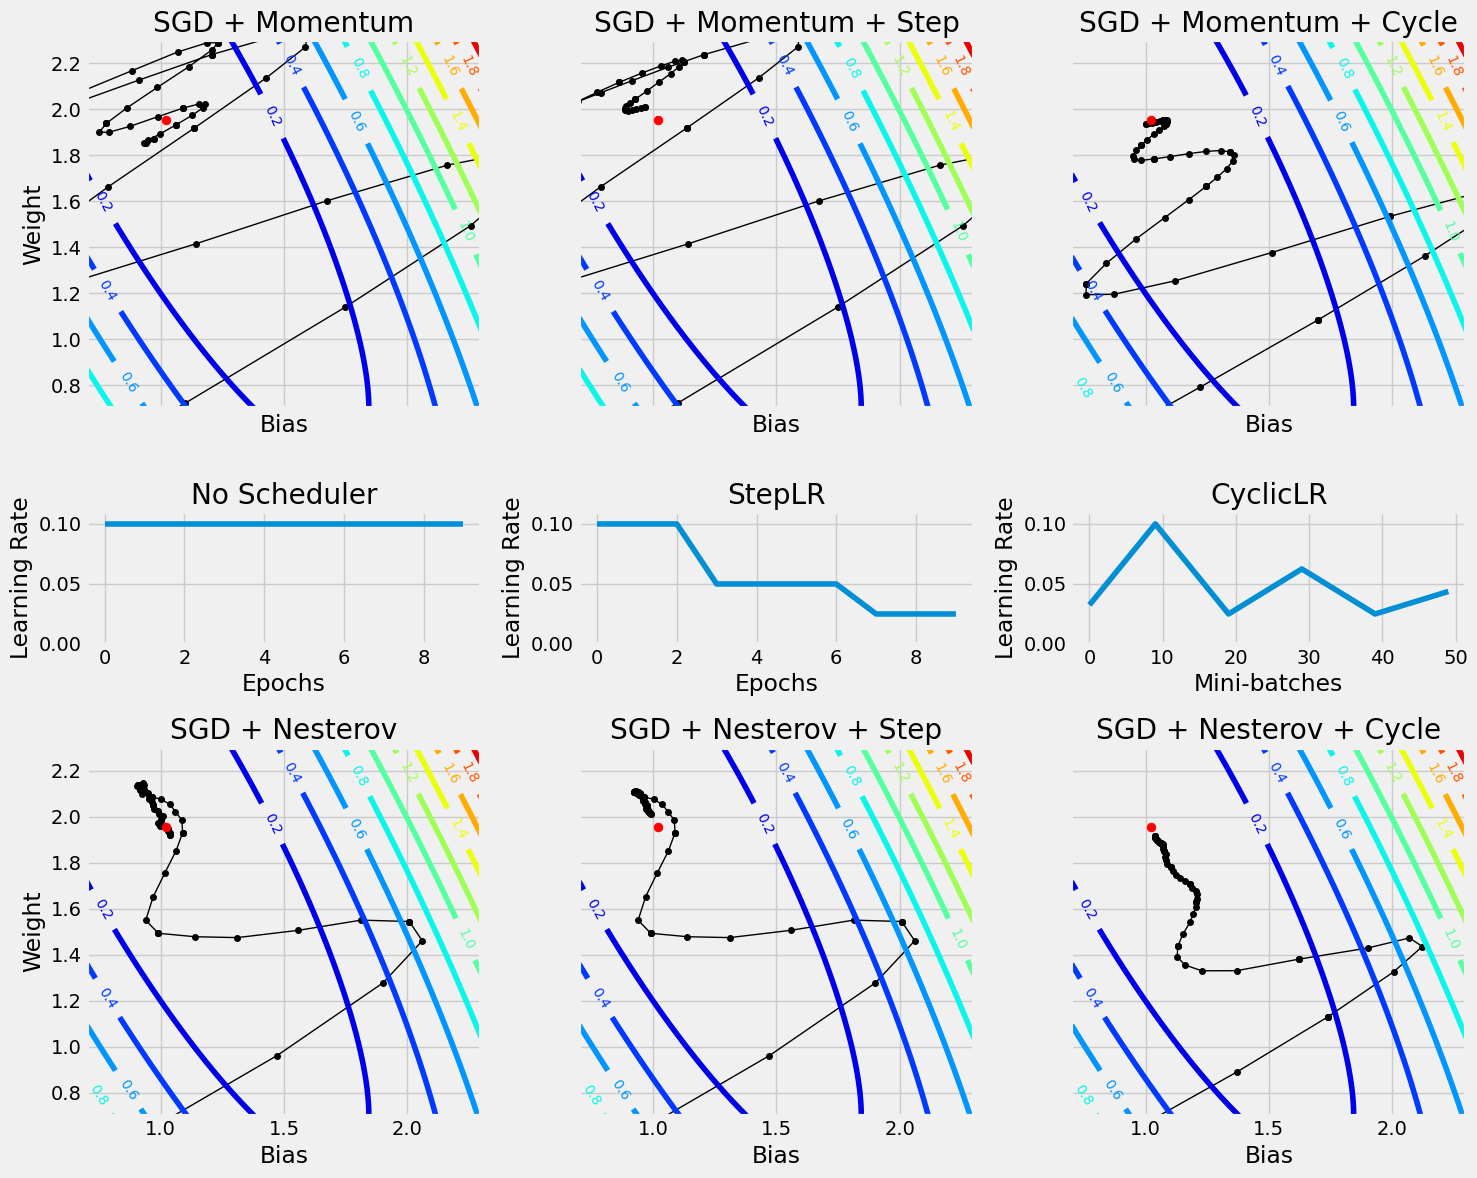

In [ ]:
fig = figure28(results, b, w, bs, ws, all_losses)
